### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [9]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [10]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)


data=data.reshape(1000,21,21,21,18)
position = data[:,6:15,6:15,6:15,:15].reshape(-1,15)
Bfield = data[:,6:15,6:15,6:15,15:].reshape(-1,3)


print(fileList)
print(data.shape)
print('position shape', position.shape)
print('Bfield shape', Bfield.shape)

['./Data\\MagneticField0.txt', './Data\\MagneticField1.txt', './Data\\MagneticField10.txt', './Data\\MagneticField100.txt', './Data\\MagneticField101.txt', './Data\\MagneticField102.txt', './Data\\MagneticField103.txt', './Data\\MagneticField104.txt', './Data\\MagneticField105.txt', './Data\\MagneticField106.txt', './Data\\MagneticField107.txt', './Data\\MagneticField108.txt', './Data\\MagneticField109.txt', './Data\\MagneticField11.txt', './Data\\MagneticField110.txt', './Data\\MagneticField111.txt', './Data\\MagneticField112.txt', './Data\\MagneticField113.txt', './Data\\MagneticField114.txt', './Data\\MagneticField115.txt', './Data\\MagneticField116.txt', './Data\\MagneticField117.txt', './Data\\MagneticField118.txt', './Data\\MagneticField119.txt', './Data\\MagneticField12.txt', './Data\\MagneticField120.txt', './Data\\MagneticField121.txt', './Data\\MagneticField122.txt', './Data\\MagneticField123.txt', './Data\\MagneticField124.txt', './Data\\MagneticField125.txt', './Data\\Magne

In [11]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop import train_part_v1
batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=position,
    train_y=Bfield
)
###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]

train_percents = np.arange(0.8,0.85,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
loss_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in learning_rates:
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_percent*0.9,train_percent*0.1,1.0-train_percent])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
            test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            fc_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':fc_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
            RMSE_history, RMSE_val_history, loss_history, iter_history, loss_val_history,epoch_stop = train_part_v1(model=fc_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    loss_val_history_end[index] = loss_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)


train_percent 0.8
Epoch 0, Iteration 1930, loss = 0.0012
Got RMSE 0.0037946708034723997


c:\Users\14032\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Got RMSE 0.003801419399678707

Validation loss decreased (inf --> 0.001181).  Saving model ...
Epoch 1, Iteration 3860, loss = 0.0003
Got RMSE 0.0015617639292031527
Got RMSE 0.001553668174892664

Validation loss decreased (0.001181 --> 0.000322).  Saving model ...
Epoch 2, Iteration 5790, loss = 0.0002
Got RMSE 0.0012668475974351168
Got RMSE 0.001264212536625564

Validation loss decreased (0.000322 --> 0.000178).  Saving model ...
Epoch 3, Iteration 7720, loss = 0.0002
Got RMSE 0.0012585925869643688
Got RMSE 0.0012549154926091433

EarlyStopping counter: 1 out of 5
Epoch 4, Iteration 9650, loss = 0.0002
Got RMSE 0.0012540984898805618
Got RMSE 0.0012522334000095725

EarlyStopping counter: 2 out of 5
Epoch 5, Iteration 11580, loss = 0.0002
Got RMSE 0.0012581718619912863
Got RMSE 0.001257137511856854

EarlyStopping counter: 3 out of 5
Epoch 6, Iteration 13510, loss = 0.0002
Got RMSE 0.001259006094187498
Got RMSE 0.001257469062693417

EarlyStopping counter: 4 out of 5
Epoch 7, Iteration 154

In [12]:
torch.save(fc_network, 'EMS_ANN.pt')	# 这里会存储迄今最优模型的参数

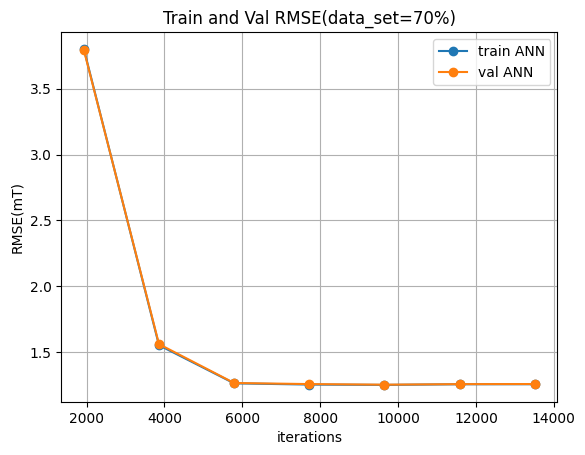

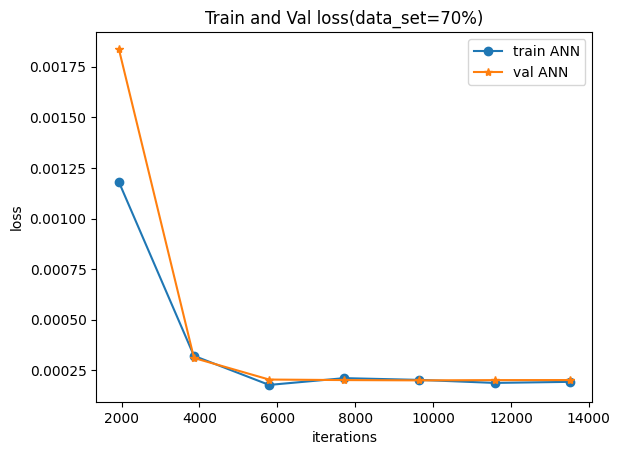

In [13]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val RMSE(data_set=70%)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop]*1000,'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop]*1000,'-o')
plt.legend(['train ANN','val ANN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.grid()
plt.show()


plt.title('Train and Val loss(data_set=70%)')
plt.plot(iter_history[0:epoch_stop],loss_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],loss_val_history[0:epoch_stop],'-*')
plt.legend(['train ANN','val ANN'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

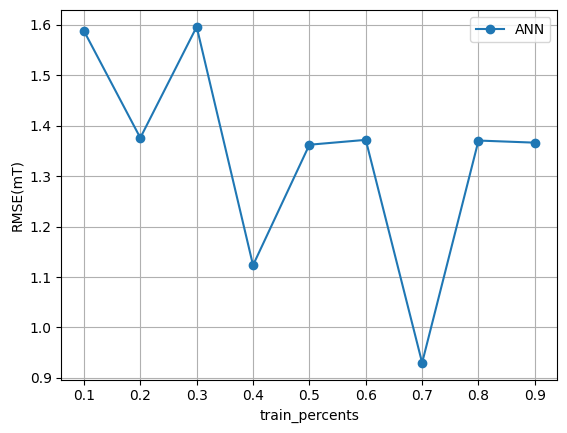

In [9]:
plt.plot(train_percents,RMSE_val_history_end*1000,'-o')
plt.xlabel('train_percents')
plt.ylabel('RMSE(mT)')
# plt.ylim([0,25])
plt.grid()
plt.legend(['ANN'])
plt.show()

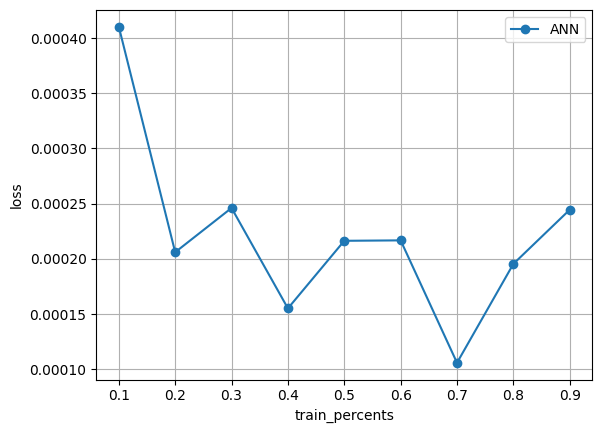

In [10]:
plt.plot(train_percents,loss_history_end,'-o')
plt.xlabel('train_percents')
plt.ylabel('loss')
plt.legend(['ANN'])
plt.grid()
plt.show()